<h2>Computer lab 3, Waves Unit 
 (module CIEM3000)</h2>

<h1 style="color:#00BFFF;"> SWASH modelling of the laboratory setup </h1>
<hr style="height:2px;border:none;color:#333;" />
<p><div style="float: right;"> </div>


In the following you will use the phase-resolving model SWASH to simulate wave transformation over the bed profile used during the experiments (see figure below).   <br> <br> 

<div style="float: center;"><img style="border:1.px solid black;" src="bathymetry_image.jpg"  WIDTH=80% ALIGN="center"/></div>

<h3 style="color:#00BFFF;"> Input file description </h3>
<hr style="height:1px;border:none;color:#333;" />
 
 An example input file (called `exp.sws`) is provided in the zip file and copied below. To prepare for the upcoming lab experiment, you will need to run SWASH for different conditions, and thus to modify this model input file (e.g., to vary wave characteristics and water level, but also probably to define new output files or modify their content). 
 
<div style="float: right;"><img style="border:1.5px solid black;" src="inputfile_image2.png"  WIDTH=90% ALIGN="center"/></div>


<br>  <br>The provided input is briefly described below. See also the [online user manual](https://swash.sourceforge.io/online_doc/swashuse/swashuse.html) for more information. 

- **(1)** The model is used in 1D mode (normally incident waves propagating over an alongshore uniform beach). The domain extends from $x=0$ to $x=35$m with 350 computational cells, leading to a $dx$ of 0.10 m (see [manual](https://swash.sourceforge.io/online_doc/swashuse/swashuse.html#model-description) for more details on the definition of the computational grid). Three layers are used for the vertical discretization.
- **(2)** The bed profile is read from the text file 'bed_profile.bot'.
- **(3)** SWASH is used in non-hydrostatic mode (important because the waves are not necessarily in shallow water), the breaking model is activated with default values, and a low friction coefficient is imposed. See [here](https://swash.sourceforge.io/online_doc/swashuse/swashuse.html#physical-parameters) for more details on the breaking model and friction.
- **(4a)** The water level (and thus the depth at the most offshore point of our domain) is set to 0.50m. 
- **(4b)** We further prescribe a standard JONSWAP spectrum ($\gamma = 3.3$) with $H_{m0} = 0.07$ m and $T_p=2$ s at the offshore boundary of our domain ($x$ = 0 m). The ADDBOUND command means that bound long waves are added to the irregular sea-swell waves at the offshore boundary. A weakly reflective boundary condition is imposed at the wave paddle (See also [here](https://swash.sourceforge.io/online_doc/swashuse/swashuse.html#initial-and-boundary-conditions1) for more detail on the boundary conditions). 
- **(5a)**: Definition of a single [output location](https://swash.sourceforge.io/online_doc/swashuse/swashuse.html#output-quantities-locations-and-formats) point (saved in text file 'gauge1.tbl'). The first line provides the coordinate of the output point (x=8m, y=0). The second defines the variables that are saved at this location. Outputs are saved every 0.05 seconds as of $t=0$. 
- **(5b)**: Definition of an output grid (first line) and of the variables to be saved at all grid points in the file 'grid_output.tbl' (second line). In this example the grid covers the full computational domain. Outputs are saved every 0.1 seconds starting at $t=0$.
-  **(6)**: This command orders SWASH to start the computation. In this case, time step for the simulation is 0.025 seconds and the total run duration is 2 min (format for the time is hhmmss.xxx where hh=hours, mm=minutes, ss=seconds and xxx milliseconds). 

 <h3 style="color:#00BFFF;"> Running SWASH </h3>
<hr style="height:1px;border:none;color:#333;" />   

In the same zip folder we also added the SWASH executable. To run it (if you work with Windows), open a Command prompt window (or DOS prompt) and navigate to the proper directory (the one containing the executable and the `.sws` input file). Alternatively you can use your file explorer to navigate to the right folder, use "shift"+"right click" and select "open in terminal" in the drop down list.

You can then type `.\swashrun input_file_without_extension`  where `input_file_without_extension` is the name of the input file you want to run without the .sws extension. In case of problem, please start by checking the .prt and .erf files (print and error files) that should be generated in the process. 

For those working with other operating systems, please re-check **Exercise 2 of the MFTBT Unit** on the CIEM3000 Brightspace (Course Documents/Practical/Exercise 2) for detailed instructions. This Brightspace folder also includes a general introduction about the model, explanations about the different files it creates, etc. <br>

<h3 style="color:#00BFFF;">Loading in some basic packages for calculations and operations</h3>
<hr style="height:1px;border:none;color:#333;" />

In [1]:
import numpy as np                   #importing numpy package for scientific computing
import matplotlib.pyplot as plt      #importing matplotlib package for plots
from scipy.signal import welch
import matplotlib
from matplotlib import animation
#from IPython.display import display, Image

<h3 style="color:#00BFFF;">Some functions to read the output files</h3>
<hr style="height:1px;border:none;color:#333;" />

Below you can find a simple function that reads the first SWASH output table (called 'gauge1.tbl' and described in frame (5a) in the [original SWASH input file](#inputfile)). If you change the output variables you will need to change this function as well - in that case, start by opening the file with a text editor to get a better idea of how it is built. 

In [2]:
def read_point_output(name_table):
    '''reads the wave gauge output type 
            input: name_table is the name of the output table (e.g. name_table="gauge1.tbl" in the original SWASH input file)
            outputs:
                t: vector containing the time in s
                eta: vector containing the surface elevation in m
                ux: vector containing the depth averaged horizontal velocity in m/s
    '''
    
    gauge = np.loadtxt(name_table,skiprows=7)

    t   = gauge[:,0] #time vector (s)
    eta = gauge[:,1] #water level (m)
    ux  = gauge[:,2] #depth-averaged velocity in the x-direction (m/s)
    #uy = gauge[:,3] #depth-averaged velocity in the y-direction (0 at all time because we are looking at a 1D case)
    
    return t, eta, ux #, uy

The function below deals with the second type of output defined in the provided input file (indicated by 5b in the [original input file](#inputfile)), where the data is saved over a predefined grid (timeseries of multiple variables at multiple locations combined in one text file). 

In [3]:
def read_grid_output(name_table,nx):
    ''' time, eta, ux, uy = read_singlepointoutput(name_table)
    read grid output
    inputs: name_table : name of the table which needs to be read (e.g., grid_output.tbl)
          nx: number of cells according to the file 
    outputs:
          time: time vector (s) of length nt  
          x: cross-shore location (m) of length nx 
          eta: array of size nx*nt containing the surface elevation (m)
                                  with respect to still water level 
          zbed: bed level (m) of length nx
          ux: array of size nx*nt containing the depth averaged horizontal velocity (m)
          h: array of size nx*nt containing the instantaneous water depth (m)'''

    
    grp = np.loadtxt(name_table,skiprows=0) #load file
    
    ns,no=grp.shape  #check dimensions of the file
                     
    nt = round(ns/nx)            # number of time steps saved in the output 
                                 # (note that the sampling interval for the output file may be different from the dt used in the calculations)
    A = np.reshape(grp,(nx,nt,no),order="F")  #we reshape the array grp as a 3D matrix of dimension nx, nt, no, where no is the number of outputed variables
    
    time =  A[0,:,0]  
    x    =  A[:,0,1]  
    eta  =  A[:,:,2] 
    zbed = -A[:,0,3]
    ux   =  A[:,:,4]
    h    =  A[:,:,6]


    return time, x, eta, zbed, ux, h

<h1 style="color:#00BFFF;">First visualizations </h1>
<hr style="height:2px;border:none;color:#333;" />

<h3 style="color:#00BFFF;">Plot data from first output file (timeseries at a single location)</h3>
<hr style="height:1.5px;border:none;color:#333;" />

You can use the lines below to read and plot the data from the first output file (defined as timeseries at x=1m).

Text(0, 0.5, 'x-velocity [m/s]')

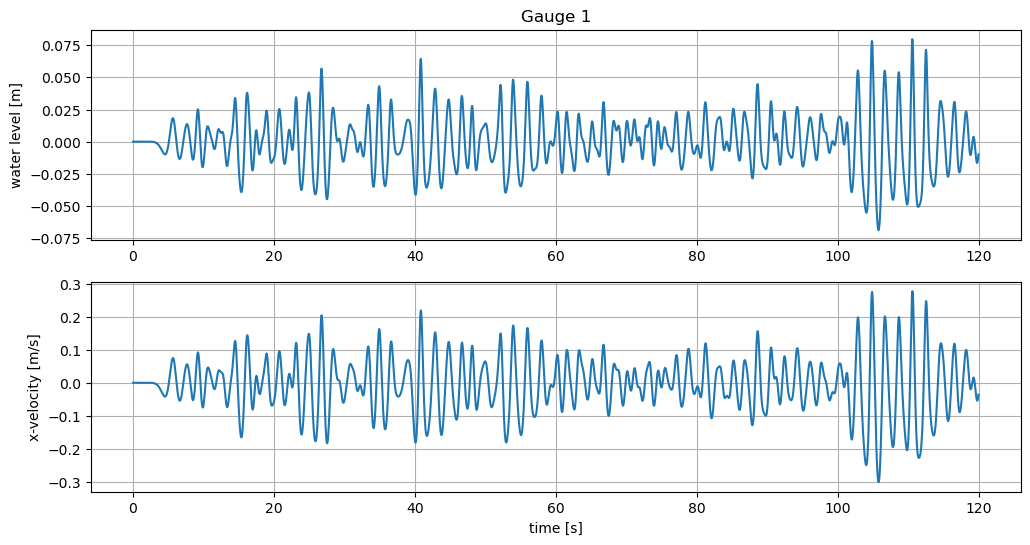

In [4]:
# read data from the single point output file
t1,eta1,ux1 = read_point_output("test_SW/gauge1.tbl")

#plotting results
plt.figure(figsize=(12,6))

plt.subplot(2, 1, 1)
plt.plot(t1,eta1)
plt.grid()
plt.ylabel('water level [m]')
plt.title('Gauge 1')

plt.subplot(2, 1, 2)
plt.plot(t1,ux1)
plt.grid()
plt.xlabel('time [s]')
plt.ylabel('x-velocity [m/s]')

<h3 style="color:#00BFFF;">Plot data from the second output file (outputs on a grid) </h3>
<hr style="height:1px;border:none;color:#333;" />

* Use the lines below to read data from the file. The outputs eta, ux and h are arrays of dimensions (**nx\*nt**), where **nx** is the number of output locations and **nt** the number of timesteps (nt=len(time)). 

In [5]:
nx= 350 # number of output locations, see also swash input file
time, x, eta, zbed, ux, h = read_grid_output("test_SW/grid_output.tbl",nx)

* Use the following lines to plot surface elevation timeseries at a selected set of locations. In this case, at 5m, 15m, 20m, and 25m  (see vector xi below)

Text(0.5, 0, 't [s]')

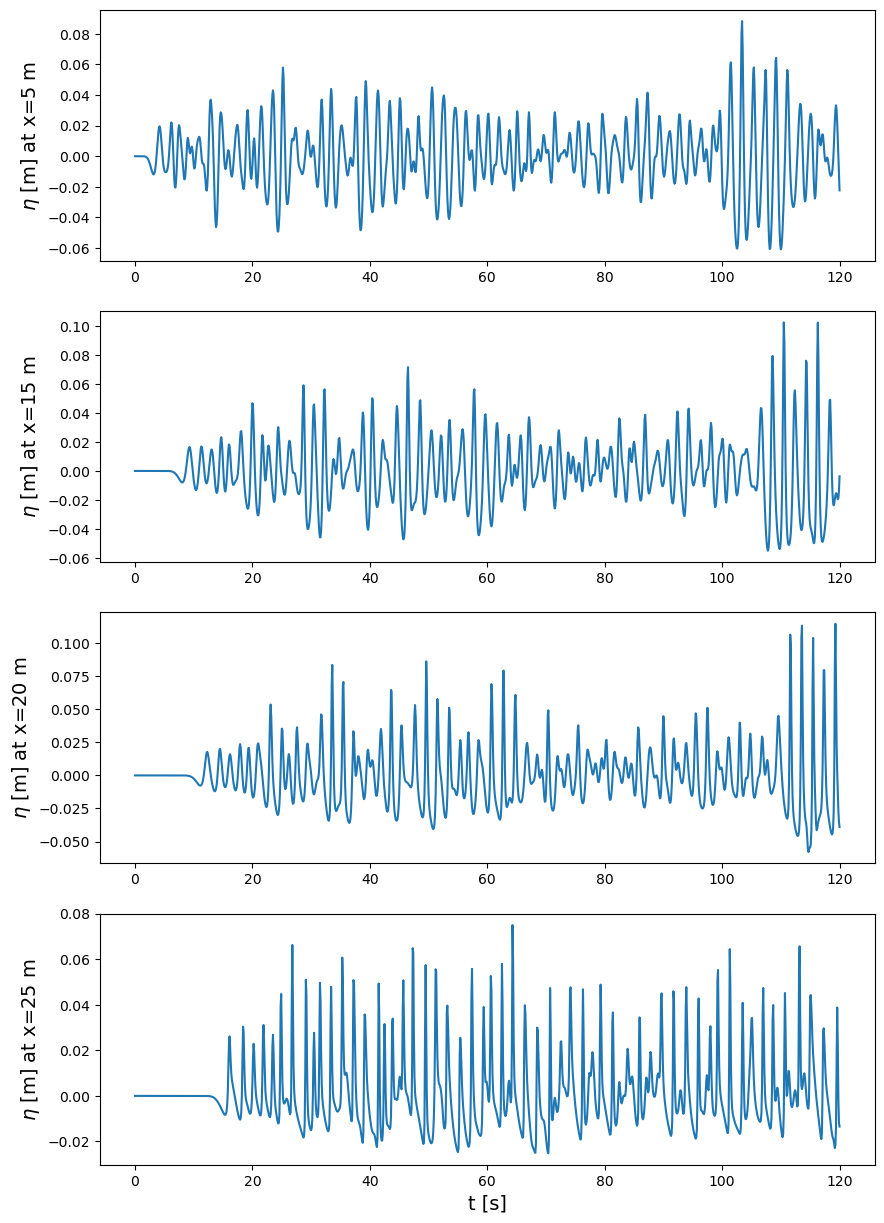

In [6]:
dx = x[1]-x[0] # dx for the output grid

xi = (5, 15, 20 , 25) #positions at which you want to plot the timeseries in meters

mm=np.round(xi/dx)
nxi = mm.astype(int) # corresponding indices 

plt.figure(figsize=(10,15))

for i in range(len(xi)):
    plt.subplot(len(xi), 1, i+1)
    plt.plot(time,eta[nxi[i],:])    
    plt.ylabel('$\eta$ [m] at x=' +str(xi[i]) +' m',fontsize=14)
    
plt.xlabel('t [s]',fontsize=14)

Note that the surface elevation is defined relative to the still water level (=initial water level, before any wave setup/setdown builds up). For the locations picked in this example, that means that the elevation is zero until the first waves reach the output location. For points which would be situated on the part of the beach which is initially dry (e.g. at $x=30$ m for a water depth d0=0.5m), the surface elevation timeseries would start at a non-zero value (=initially equal to bed elevation at this location). 

<h3 style="color:#00BFFF;">Make an animation from the grid outputs</h3>
<hr style="height:1px;border:none;color:#333;" />

This script will create and save an animation showing the space and time evolution of the surface elevation and velocity field predicted by SWASH. 

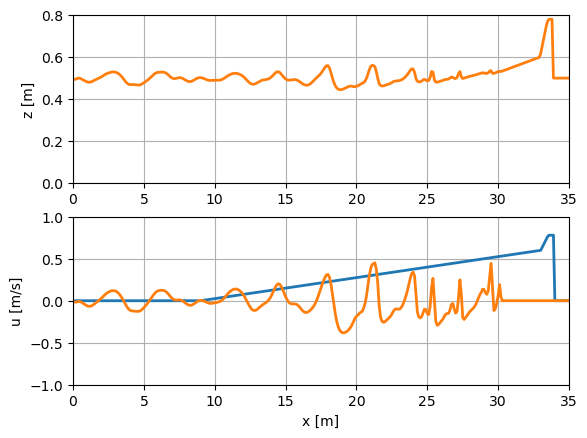

In [7]:
# here we include 100/deltaData% of the time steps to speed up the time needed to create the 
# animation... the closer deltaData to 1, the smoother the animation will be but payed with time (and noisy fans!)
deltaData = 50
eta_new = eta[:, ::deltaData][:, :] #skips deltaData time steps
ux_new = ux[:, ::deltaData][:, :]

Nt = eta_new.shape[1] # number of frames you want to include in the animation 
                  

#make animation

#define figure in which the plots will be made
fig, (ax1, ax2) = plt.subplots(2,1)

line1, = ax1.plot([], [], lw=2)
line2, = ax1.plot([], [], lw=2)
line3, = ax2.plot([], [], lw=2)
line4, = ax2.plot([], [], lw=2)
ax1.set_xlim(0, 35)
ax1.set_ylim(0, 0.8)
ax2.set_xlim(0, 35)
ax2.set_ylim(-1, 1)
ax1.grid()
ax2.grid()
ax1.set_ylabel('z [m]')
ax2.set_xlabel('x [m]')
ax2.set_ylabel('u [m/s]')
    
def init():
    line1.set_data([], [])
    return line1,

#define animation function
def animate(t_i):
    etai = eta_new[:,t_i]; 
    z_b = zbed 
    ui   =  ux_new[:,t_i] 
    line1.set_data(x, z_b+0.5)
    line2.set_data(x, etai+0.5)
    line3.set_data(x, z_b+0.5)
    line4.set_data(x, ui)
        
    return line1,line2,line3,line4,

#call the animator
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=Nt, interval=10, repeat=False)

#save as animated gif
writergif = animation.PillowWriter(fps=5) 
anim.save('animation_eta_u.gif', writer=writergif,dpi=300)

#save as .mov
#anim.save('animation_eta_u2.mov', fps=30, dpi=300,bitrate=400, extra_args=['-vcodec', 'libx264'])

<h1 style="color:#00BFFF;">Data analysis </h1>
<hr style="height:2px;border:none;color:#333;" />


* Before calculating any wave statistics, make sure you remove the start of the simulation where wave conditions are not stationary yet. **Are the 2 minutes of simulation sufficient for the analysis you want to conduct or do you need to increase the run duration?** 

* In Q2 we have provided several functions to analyse wave data in the time and frequency domain that you can re-use/extend when needed (computer exercises 1-3). For the spectral calculations, you can either re-use the function from Computer lab 2 (Q2) or use the more evolved built-in Python function `welch()`.

* In your analysis, you may need to filter your data in the frequency domain, to keep only the signal related to the sea-swell waves or infragravity waves for instance. To do so, you can use the function **frequency_filter()** defined below. This function will also come in handy when analysing the lab data (as will be any other code you developed to analyse your SWASH outputs!)

In [8]:
def frequency_filter(data, Fs, f_low, f_high):
    ''' frequency_filter is a simple spectral filter in which the unwanted frequencies (below f_low and above f_high) 
        are set to zero before coming back to the time-domain
            input: data timeseries you want to filter
                   F_s the sampling frequency of this timeseries (Hz)
                   f_low and f_high are the limits of the band pass filter (Hz)
            output: data_filtered band pass filtered timeseries (same unit as the input timeseries)
    '''
    
    N = len(data)

    fft_data = np.fft.fft(data)  # fourier transform of the signal

    freq_vector = np.fft.fftfreq(N, d=1/Fs) # corresponding (2-sided) frequency axis (includes positive and negative values)
    
    idx = np.where((abs(freq_vector) > f_high) | (abs(freq_vector) <= f_low)) # we select the indices to filter out
    
    fft_data[idx]=0.  # we set the the fourier coefficients corresponding to abs(f)>f_high and abs(f)<f_low to zero

    data_filtered = np.fft.ifft(fft_data).real  # we come back to the time domain with an inverse Fourier transform
    
    return data_filtered
